In [1]:
import pandas as pd
import datetime
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
#from lime import lime_tabular

In [2]:
import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [240]:
# read in master file
df_orig=pd.read_excel("ContouringAndPlanningTimeEst.xlsx")
# exclude planned delays
df_orig=df_orig[df_orig['Category_x']!='Planned Delay 3']
#df_orig=df_orig[df_orig['Category_x']!='planned Delay 3']
# Correcting Standard 2 = Standard 3
#df_orig = df_orig.replace({'Category_x': {'Standard 2': 'Standard 3', 
                             #   'Urgent ICU/SDU 2':'Urgent 2'}})

In [306]:
df_orig['SiteGroup'].unique()

array(['GENITOURINARY(GU)', 'BREAST', 'GI UPPER', 'GYNAE', 'Oligomets',
       'SARCOMA', 'ENT (HEAD & NECK)', 'LUNG', 'CNS', 'GI LOWER', 'SKIN',
       'LYMPHOMA', 'EYE', 'ENDOCRINE', 'Unknown', 'PAEDIATRIC'],
      dtype=object)

In [238]:
# read in instance file
df_ins = pd.read_excel("ins_201910_202002.xlsx")


In [307]:
df_ins.shape
df_ins['SiteGroup'].unique()

array(['ENT (HEAD & NECK)', 'BREAST', 'LUNG', 'CNS', 'GENITOURINARY(GU)',
       'GI UPPER', 'GYNAE', 'LYMPHOMA', 'SARCOMA', 'GI LOWER',
       'ENDOCRINE', 'SKIN', 'EYE', 'PAEDIATRIC'], dtype=object)

## ML models

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

### data to train model

In [186]:
### most recent 6-month data
#df1920 = df_orig[pd.to_datetime(df_orig['CreatedDate']).dt.year>=2019]
df1920 = df_orig[(pd.to_datetime(df_orig['CreatedDate']).dt.date >= pd.to_datetime("2019-06-01"))&
                (pd.to_datetime(df_orig['CreatedDate']).dt.date <= pd.to_datetime("2019-12-31"))]
df1920.shape


(2358, 23)

In [187]:
df_meet=df1920[df1920['WaitTime']<=14]
df_meet.shape

(1544, 23)

In [ ]:
'''df_forins = df_orig[(pd.to_datetime(df_orig['CreatedDate']).dt.date >= pd.to_datetime("2019-06-01"))&
                (pd.to_datetime(df_orig['CreatedDate']).dt.date <= pd.to_datetime("2021-12-31"))]
df_forins.to_excel("master_2019-2020.xlsx")'''

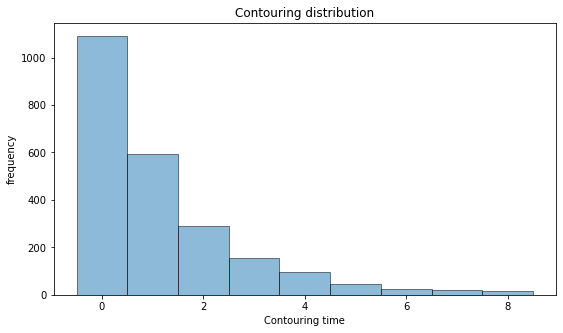

In [327]:
'''df1920['TimeBtw_Sim_BkTx'] = df1920.apply(
    lambda row: row['ContourDur'] if row['TimeBtw_Sim_BkTx']<0 else row['TimeBtw_Sim_BkTx'],
    axis=1
)'''

df1920['ContourDur'] = df1920['ContourDur+1']-1
df1920["ContourDur"] = df1920["ContourDur"].fillna(df1920["ContourDur"].mode()[0])

plt.figure(figsize=[9,5])
bins = range(0,10)

y = df1920["ContourDur"]
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('Contouring time')
plt.ylabel('frequency')
plt.title('Contouring distribution')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

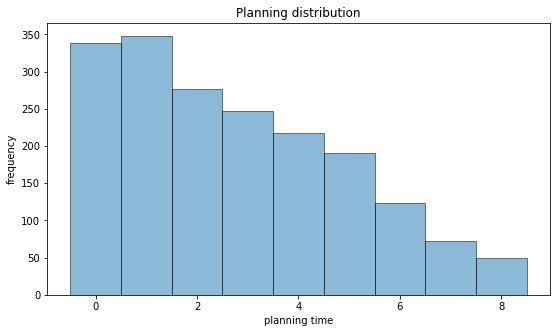

In [308]:
df1920['PlanDur'] = df1920["TestPlanDur"] - 1
#df1920["PlanDur"] = df1920["PlanDur"].fillna(df1920["PlanDur"].mode()[0])
#df1920=df1920[df1920['WaitTime']<=14]

plt.figure(figsize=[9,5])
bins = range(0,10)

y = df1920["PlanDur"]
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('planning time')
plt.ylabel('frequency')
plt.title('Planning distribution')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

### contouring

In [329]:
target_y = "ContourDur"
#df_meet = df1920[df1920['WaitTime']<=14]
features = ['SiteGroup', 'Category_x','TltDose','TxFracs']
df_clf = df1920[features + [target_y]]


In [330]:
df_clf["SiteGroup"] = df_clf["SiteGroup"].fillna(df_clf["SiteGroup"].mode())
df_clf["Category_x"] = df_clf["Category_x"].fillna(df_clf["Category_x"].mode())
df_clf["TltDose"] = df_clf["TltDose"].fillna(df_clf["TltDose"].mode()[0])
df_clf["TxFracs"] = df_clf["TxFracs"].fillna(df_clf["TxFracs"].mode()[0])
#df_clf['Intent'] = df_clf['Intent'].fillna(df_clf['Intent'].mode()[0])
df_clf['ContourDur'] = df_clf["ContourDur"].fillna(df_clf["ContourDur"].median())

In [331]:
#df_clf["Intent"].isnull().values.any()

In [332]:
dummy = pd.get_dummies(df_clf[["SiteGroup","Category_x"]], prefix=['Site','Categ']) #, drop_first=True)
df_cont = pd.concat([df_clf, dummy], axis=1)
#print( df_clf.filter(like="Sitegroup_y",axis=1).head() )

## drop the original categorical column
df_cont = df_cont.drop(['SiteGroup','Category_x'], axis=1)

In [333]:
# train-test spli4
df_train, df_test = model_selection.train_test_split(df_cont, test_size=0.3, random_state=1)
## print info
print("X_train shape:", df_train.drop(target_y,axis=1).shape, "| X_test shape:", df_test.drop(target_y,axis=1).shape)
print("y_train mean:", round(np.mean(df_train[target_y]),2), "| y_test mean:", round(np.mean(df_test[target_y]),2))
print(df_train.shape[1], "features:", df_train.drop(target_y,axis=1).columns.to_list())

X_train shape: (1650, 19) | X_test shape: (708, 19)
y_train mean: 1.25 | y_test mean: 1.28
20 features: ['TltDose', 'TxFracs', 'Site_BREAST', 'Site_CNS', 'Site_ENDOCRINE', 'Site_ENT (HEAD & NECK)', 'Site_EYE', 'Site_GENITOURINARY(GU)', 'Site_GI LOWER', 'Site_GI UPPER', 'Site_GYNAE', 'Site_LUNG', 'Site_LYMPHOMA', 'Site_PAEDIATRIC', 'Site_SARCOMA', 'Site_SKIN', 'Categ_Emergency 1', 'Categ_Standard 3', 'Categ_Urgent 2']


In [334]:
df_test_copy = df_test

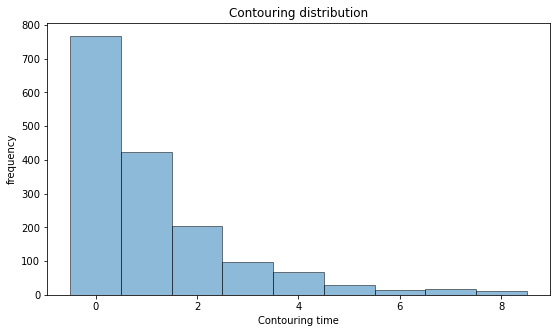

In [335]:
df_train[target_y]
plt.figure(figsize=[9,5])
bins = range(0,10)

y = df_train[target_y]
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('Contouring time')
plt.ylabel('frequency')
plt.title('Contouring distribution')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [254]:
# 0-1, class 0; 2-5, class 1, >5, class 2
df_train.loc[df_train[target_y] <=0, 'ContourGroup'] = 0
df_train.loc[(df_train[target_y] <=2)&(df_train[target_y]>=1), 'ContourGroup'] = 1
df_train.loc[df_train[target_y] >= 3, 'ContourGroup'] = 2
df_train = df_train.drop(columns=[target_y])

df_test.loc[df_test[target_y] <= 0, 'ContourGroup'] = 0
df_test.loc[(df_test[target_y] <=2)&(df_test[target_y]>=1), 'ContourGroup'] = 1
df_test.loc[df_test[target_y] >= 3, 'ContourGroup'] = 2
df_test = df_test.drop(columns=[target_y])

In [255]:
X_train = df_train.drop('ContourGroup', axis=1).values
y_train = df_train['ContourGroup'].values

X_test = df_test.drop('ContourGroup', axis=1).values
y_test = df_test['ContourGroup'].values
feature_names = df_train.drop('ContourGroup', axis=1).columns.tolist()

In [256]:
### Random Forest
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf_rf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_rf.fit(X_train,y_train)

y_pred = clf_rf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.614406779661017


In [257]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 80, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [10, 12, 15],
    'n_estimators': [100, 200, 300]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [258]:
# evaluate random search
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [259]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, X_test, y_test)

#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


Fitting 3 folds for each of 324 candidates, totalling 972 fits


In [260]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}

In [261]:
grid_search.score(X_test, y_test)

0.635593220338983

In [262]:
y_rf_pred=grid_search.predict(X_test)
cm_rf = confusion_matrix(y_test, y_rf_pred)
print(cm_rf)
print(classification_report(y_test, y_rf_pred))

[[270  54   4]
 [ 99 148  10]
 [ 15  76  32]]
              precision    recall  f1-score   support

         0.0       0.70      0.82      0.76       328
         1.0       0.53      0.58      0.55       257
         2.0       0.70      0.26      0.38       123

    accuracy                           0.64       708
   macro avg       0.64      0.55      0.56       708
weighted avg       0.64      0.64      0.62       708



In [263]:
### RMSE (days)
y_pred_days = []
for i in y_pred: #y_rf_pred:
    if i == 0:
        y_pred_days.append(0)
    if i == 1:
        y_pred_days.append(2)       
    if i == 2:
        y_pred_days.append(3)
        
y_true_days = df_test_copy[target_y].values
from sklearn.metrics import mean_squared_error

#pred_filtered = y_pred_days.remove(3)
#true_filtered = [x for x in y_true_days if x <= 2]

rmse = mean_squared_error(y_pred_days, y_true_days, squared=False)
#rmse = mean_squared_error(pred_filter, true_filtered, squared=False)
print(rmse)

1.7858514878687881


In [207]:
'''# save the model
from pickle import dump
dump(grid_search, open('Contouring_model.pkl', 'wb'))'''

In [338]:
### Gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier
gbclf = GradientBoostingClassifier().fit(X_train, y_train)
gbclf.score(X_test, y_test)

0.27177700348432055

In [344]:
y_pred = gbclf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.27177700348432055

In [341]:
# Create the parameter grid based on the results of random search 
param_grid = {
    #'bootstrap': [True],
    'max_depth': [50, 60, 80, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [10, 12, 15],
    'n_estimators': [100, 200, 300]
}
# Create a based model
gb = GradientBoostingClassifier()
# Instantiate the grid search model
gb_grid_search = GridSearchCV(estimator = gb, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
gb_grid_search.fit(X_train, y_train)
gb_grid_search.best_params_

best_grid = gb_grid_search.best_estimator_
best_grid

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/Users/fanjia/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


KeyboardInterrupt: 

In [ ]:
gb_grid_search.score(X_test, y_test)

#### ContourGroup rules

In [264]:
a = df_cont[df_cont[target_y]<=0][target_y]
np.percentile(a, 75)

0.0

In [265]:
b = df_cont[(df_cont[target_y]<=2)&(df_cont[target_y]>=1)][target_y]
np.percentile(b, 75)

2.0

In [266]:
c = df_cont[df_cont[target_y]>=3][target_y]
np.percentile(c, 25)

3.0

#### Predict Instance Data

In [267]:
df_train

,TltDose,TxFracs,Site_BREAST,Site_CNS,Site_ENDOCRINE,Site_ENT (HEAD & NECK),Site_EYE,Site_GENITOURINARY(GU),Site_GI LOWER,Site_GI UPPER,Site_GYNAE,Site_LUNG,Site_LYMPHOMA,Site_PAEDIATRIC,Site_SARCOMA,Site_SKIN,Categ_Emergency 1,Categ_Standard 3,Categ_Urgent 2,ContourGroup
2443,6000.0,25.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.0
5706,2500.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1.0
6297,3000.0,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.0
5711,5750.0,25.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1.0
1793,3000.0,10.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4086,2000.0,5.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0
3900,4500.0,15.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1.0
4633,5400.0,27.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1.0
926,7000.0,35.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2.0


In [268]:
all_columns = df_train.columns # index object
model_features = df_train.columns.to_list()
model_features.remove('ContourGroup')

In [270]:
df_ins.head()

,Unnamed: 0,MRN,CreatedDate,SiteGroup,Intent,Category_x,SimApptDuration,TltDose,TxFracs,TxApptDuration,Team,CT,linacs,TxStartDt,WaitTime
0,0,48245,2020-01-30,ENT (HEAD & NECK),Palliative,Urgent 2,45,800.0,1.0,45,1,3 4,1 3 4 14,2020-02-01,2
1,1,162839,2019-10-02,ENT (HEAD & NECK),Curative,Standard 3,45,400.0,2.0,30,1,3 4,1 3 4 14,2019-10-23,21
2,4,282105,2020-02-04,ENT (HEAD & NECK),Palliative,Urgent 2,30,1000.0,1.0,30,1,3 4,1 3 4 14,2020-02-11,7
3,6,357124,2019-11-22,ENT (HEAD & NECK),Palliative,Urgent 2,30,800.0,1.0,30,1,3 4,1 3 4 14,2019-11-22,0
4,7,374634,2019-10-15,ENT (HEAD & NECK),Curative,Standard 3,30,7000.0,35.0,30,1,3 4,1 3 4 14,2019-10-29,14


In [271]:
dfDur = df_ins[['SiteGroup','Category_x','TltDose','TxFracs']]
dummy_new = pd.get_dummies(dfDur[["SiteGroup","Category_x"]], prefix=['Site','Categ']) #, drop_first=True)
df_new = pd.concat([dfDur, dummy_new], axis=1)
## drop the original categorical column
df_new = df_new.drop(['SiteGroup','Category_x'], axis=1)

In [272]:
df_new = df_new.reindex(columns = df_new.columns | all_columns)
df_new.fillna(0, inplace=True)
df_new = df_new[model_features]

In [273]:
X_new = df_new.values
y_new_pred = grid_search.predict(X_new)
y_new_days = []
for i in y_new_pred:
    if i == 0:
        y_new_days.append(0)
    if i == 1:
        y_new_days.append(2)       
    if i == 2:
        y_new_days.append(3)
df_ins['Contour'] = y_new_days

### Planning

In [309]:
#df1920['PlanCompl_TxBook'] = df1920['FinalPlanCompleteDate']-df1920['TxApptCreatedDt']
#df1920['PlanCompl_TxBook']=df1920['PlanCompl_TxBook'].dt.days
#df1920['TxStart_PlanCompl'] = df1920['TxStartDt']-df1920['FinalPlanCompleteDate']
#df1920['TxStart_PlanCompl']=df1920['TxStart_PlanCompl'].dt.days
#df_meet = df1920[df1920['WaitTime']<=14]
df1920['PlanDur']=df1920['TestPlanDur']-1
df1920.shape

(2358, 25)

In [217]:

#df_meet['TxStart_PlanCompl'] = df_meet['TxStart_PlanCompl'].fillna(-1)
#df_meet['Planning'] = df_meet.apply(
#    lambda row: row['Tx-TxBook'] if row['TxStart_PlanCompl'] < 0 else row['PlanCompl_TxBook'],
#    axis=1)
# if Tx appt is after plan complete, planning time = planComplete - TxBooked
# if Tx appt if before final plan complete, planning time = Tx - TxBooked

#df1920.dropna(subset=['Planning'], inplace=True)


In [310]:
# remove outliers by planning time
df_meet = df1920[df1920['WaitTime']<14]
df_meet['z_score_contour']=stats.zscore(df_meet['PlanDur'])
#df_meet = df_meet.loc[df_meet['z_score_contour'].abs()<=3]


In [311]:
#df_meet[df_meet['PlanDur'].notnull()].shape
df_meet = df1920[df1920['PlanDur'].notnull()]
df_meet.shape

(1913, 25)

In [312]:
target_y = "PlanDur"
features = ['SiteGroup','Category_x','TltDose','TxFracs']
df_clf2 = df_meet[features + [target_y]]
df_clf2 = df_clf2[df_clf2['SiteGroup'].notnull()]
df_clf2["SiteGroup"] = df_clf2["SiteGroup"].fillna(df_clf2["SiteGroup"].mode())
df_clf2["Category_x"] = df_clf2["Category_x"].fillna(df_clf2["Category_x"].mode())
df_clf2["TltDose"] = df_clf2["TltDose"].fillna(df_clf2["TltDose"].mode()[0])
df_clf2["TxFracs"] = df_clf2["TxFracs"].fillna(df_clf2["TxFracs"].median())
df_clf2[target_y] = df_clf2[target_y].fillna(df_clf2[target_y].mode()[0])

In [313]:
df_clf2[target_y].unique()
df_clf2[target_y].median()

2.0

In [314]:
dummy = pd.get_dummies(df_clf2[["SiteGroup","Category_x"]], prefix=['Site','Categ']) #, drop_first=True)
df_plan = pd.concat([df_clf2, dummy], axis=1)

## drop the original categorical column
df_plan = df_plan.drop(['SiteGroup','Category_x'], axis=1)

In [315]:
# train-test split
df_train, df_test = model_selection.train_test_split(df_plan, test_size=0.3)
## print info
print("X_train shape:", df_train.drop(target_y,axis=1).shape, "| X_test shape:", df_test.drop(target_y,axis=1).shape)
print("y_train mean:", round(np.mean(df_train[target_y]),2), "| y_test mean:", round(np.mean(df_test[target_y]),2))
print(df_train.shape[1], "features:", df_train.drop(target_y,axis=1).columns.to_list())
df_test_copy = df_test

X_train shape: (1339, 19) | X_test shape: (574, 19)
y_train mean: 2.88 | y_test mean: 2.97
20 features: ['TltDose', 'TxFracs', 'Site_BREAST', 'Site_CNS', 'Site_ENDOCRINE', 'Site_ENT (HEAD & NECK)', 'Site_EYE', 'Site_GENITOURINARY(GU)', 'Site_GI LOWER', 'Site_GI UPPER', 'Site_GYNAE', 'Site_LUNG', 'Site_LYMPHOMA', 'Site_PAEDIATRIC', 'Site_SARCOMA', 'Site_SKIN', 'Categ_Emergency 1', 'Categ_Standard 3', 'Categ_Urgent 2']


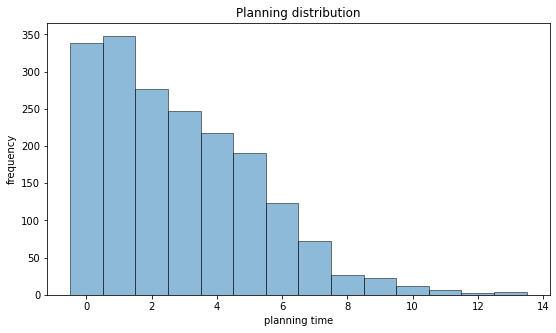

In [316]:
plt.figure(figsize=[9,5])
bins = range(0,15)

y = df_plan[target_y]
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('planning time')
plt.ylabel('frequency')
plt.title('Planning distribution')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

### Classification

In [317]:
# quantiles
np.quantile(df_plan[target_y], [0.25,0.5,0.75])

array([1., 2., 4.])

In [122]:
'''# 0-1, class 0; 2-5, class 1, >5, class 2
df_train.loc[df_train[target_y] <=2, 'PlanGroup'] = 0
df_train.loc[(df_train[target_y] <=5)&(df_train[target_y]>=3), 'PlanGroup'] = 1
df_train.loc[df_train[target_y] >=6, 'PlanGroup'] = 2
df_train = df_train.drop(columns=[target_y])

df_test.loc[df_test[target_y] <=2, 'PlanGroup'] = 0
df_test.loc[(df_test[target_y] <=5)&(df_test[target_y]>=3), 'PlanGroup'] = 1
df_test.loc[df_test[target_y] >=6, 'PlanGroup'] = 2
df_test = df_test.drop(columns=[target_y])'''


In [318]:
target_y

'PlanDur'

In [319]:
X_train = df_train.drop(target_y, axis=1).values
y_train = df_train[target_y].values

X_test = df_test.drop(target_y, axis=1).values
y_test = df_test[target_y].values
feature_names = df_train.drop(target_y, axis=1).columns.tolist()


In [320]:
### simple Random Forest
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf_rf2 = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_rf2.fit(X_train,y_train)

y_pred = clf_rf2.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.26480836236933797


In [321]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 40, 60],
    'max_features': [4, 5, 6, 7, 8],
    'min_samples_leaf': [4, 5, 6, 7, 8],
    'min_samples_split': [5, 10, 12, 15],
    'n_estimators': [100, 200, 300]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


In [323]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)


#best_grid = grid_search.best_estimato



Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


/Users/fanjia/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 20, 40, 60],
                         'max_features': [4, 5, 6, 7, 8],
                         'min_samples_leaf': [4, 5, 6, 7, 8],
                         'min_samples_split': [5, 10, 12, 15],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_

In [324]:
grid_search.score(X_test, y_test)

0.27177700348432055

In [325]:
y_rf_pred=grid_search.predict(X_test)
cm_rf = confusion_matrix(y_test, y_rf_pred)
print(cm_rf)
print(classification_report(y_test, y_rf_pred))

[[ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 72 31  7  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 30 35  9  5  5  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 15 36 20  6  4  5  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3 22 14 11 13  5  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2 15  7 12 14  6  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1 15 13  8 25  4  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 13  6  3 13  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  8

/Users/fanjia/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fanjia/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fanjia/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [326]:
rmse = mean_squared_error(y_rf_pred, y_test,squared=False)
print(rmse)

3.503855517044126


#### Planning rules

In [ ]:
a = df_plan[df_plan[target_y]<=0][target_y]
print(np.percentile(a, 90))
b = df_plan[(df_plan[target_y]<=1)&(df_plan[target_y]>=1)][target_y]
print(np.percentile(b, 90))
c = df_plan[df_plan[target_y]>=2][target_y]
print(np.percentile(c, 75))


#### rmse # days

In [ ]:
y_pred_days = []
for i in y_rf_pred:
    if i == 0:
        y_pred_days.append(0)
    if i == 1:
        y_pred_days.append(1)       
    if i == 2:
        y_pred_days.append(8)
        
y_true_days = df_test_copy[target_y].values
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_pred_days, y_true_days,squared=False)
print(rmse)


### Regression

In [345]:
df_plan = df_plan[(df_plan['PlanDur']>=0)&(df_plan['PlanDur']<=14)]
df_plan.shape

(1887, 20)

In [347]:
df_plan.columns

Index(['TltDose', 'TxFracs', 'PlanDur', 'Site_BREAST', 'Site_CNS',
       'Site_ENDOCRINE', 'Site_ENT (HEAD & NECK)', 'Site_EYE',
       'Site_GENITOURINARY(GU)', 'Site_GI LOWER', 'Site_GI UPPER',
       'Site_GYNAE', 'Site_LUNG', 'Site_LYMPHOMA', 'Site_PAEDIATRIC',
       'Site_SARCOMA', 'Site_SKIN', 'Categ_Emergency 1', 'Categ_Standard 3',
       'Categ_Urgent 2'],
      dtype='object')

In [382]:
# train-test split
target_y = 'PlanDur'
df_plan = df_plan[df_plan['PlanDur']>=0]
df_train, df_test = model_selection.train_test_split(df_plan, test_size=0.3, random_state=10)
## print info
print("X_train shape:", df_train.drop(target_y,axis=1).shape, "| X_test shape:", df_test.drop(target_y,axis=1).shape)
print("y_train mean:", round(np.mean(df_train[target_y]),2), "| y_test mean:", round(np.mean(df_test[target_y]),2))
print(df_train.shape[1], "features:", df_train.drop(target_y,axis=1).columns.to_list())
df_test_copy = df_test

X_train = df_train.drop('PlanDur', axis=1).values
y_train = df_train['PlanDur'].values

X_test = df_test.drop('PlanDur', axis=1).values
y_test = df_test['PlanDur'].values
feature_names = df_train.drop('PlanDur', axis=1).columns.tolist()

X_train shape: (1320, 19) | X_test shape: (567, 19)
y_train mean: 2.9 | y_test mean: 2.77
20 features: ['TltDose', 'TxFracs', 'Site_BREAST', 'Site_CNS', 'Site_ENDOCRINE', 'Site_ENT (HEAD & NECK)', 'Site_EYE', 'Site_GENITOURINARY(GU)', 'Site_GI LOWER', 'Site_GI UPPER', 'Site_GYNAE', 'Site_LUNG', 'Site_LYMPHOMA', 'Site_PAEDIATRIC', 'Site_SARCOMA', 'Site_SKIN', 'Categ_Emergency 1', 'Categ_Standard 3', 'Categ_Urgent 2']


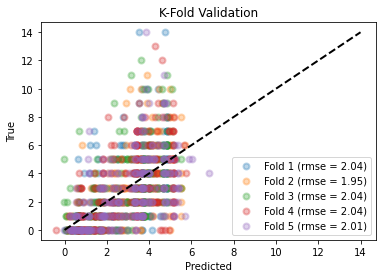

In [399]:
## call model
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=0)
## K fold validation
scores = []
rmse_list = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],
                 y_train[train]).predict(X_train[test])
    true = y_train[test]
    #score = metrics.r2_score(true, prediction)
    #scores.append(score)
    rmse = mean_squared_error(true, prediction, squared=False)
    rmse_list.append(rmse)
    plt.scatter(prediction, true, lw=2, alpha=0.3, 
                label='Fold %d (rmse = %0.2f)' % (i, rmse))
                #label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
    
### plotting predicted values against the actual Y
### Ideally, points should be all close to a diagonal line where predicted = actual
#plt.figure(figsize=[7,5])
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend(loc = "lower right")

plt.show()

In [393]:
import math
y_pred_days = [round(i) for i in y_test_pred]
y_pred_days

[3.0,
 4.0,
 4.0,
 4.0,
 1.0,
 5.0,
 3.0,
 5.0,
 2.0,
 5.0,
 1.0,
 4.0,
 3.0,
 2.0,
 1.0,
 4.0,
 2.0,
 2.0,
 -0.0,
 2.0,
 2.0,
 4.0,
 0.0,
 5.0,
 1.0,
 1.0,
 3.0,
 3.0,
 2.0,
 1.0,
 3.0,
 0.0,
 2.0,
 1.0,
 0.0,
 4.0,
 3.0,
 4.0,
 -0.0,
 1.0,
 0.0,
 4.0,
 1.0,
 4.0,
 4.0,
 3.0,
 2.0,
 1.0,
 4.0,
 3.0,
 5.0,
 1.0,
 5.0,
 0.0,
 4.0,
 4.0,
 1.0,
 3.0,
 0.0,
 1.0,
 3.0,
 5.0,
 1.0,
 4.0,
 4.0,
 3.0,
 4.0,
 4.0,
 4.0,
 1.0,
 1.0,
 3.0,
 4.0,
 4.0,
 5.0,
 4.0,
 3.0,
 1.0,
 5.0,
 4.0,
 2.0,
 2.0,
 1.0,
 3.0,
 5.0,
 1.0,
 5.0,
 2.0,
 2.0,
 4.0,
 -0.0,
 3.0,
 -0.0,
 2.0,
 4.0,
 4.0,
 4.0,
 0.0,
 4.0,
 3.0,
 4.0,
 5.0,
 2.0,
 2.0,
 3.0,
 2.0,
 1.0,
 4.0,
 3.0,
 5.0,
 2.0,
 2.0,
 4.0,
 2.0,
 2.0,
 3.0,
 4.0,
 5.0,
 2.0,
 2.0,
 4.0,
 2.0,
 4.0,
 5.0,
 4.0,
 4.0,
 5.0,
 4.0,
 5.0,
 3.0,
 1.0,
 4.0,
 4.0,
 2.0,
 4.0,
 4.0,
 4.0,
 5.0,
 2.0,
 4.0,
 5.0,
 4.0,
 0.0,
 2.0,
 2.0,
 5.0,
 4.0,
 2.0,
 1.0,
 4.0,
 5.0,
 3.0,
 4.0,
 4.0,
 0.0,
 1.0,
 1.0,
 2.0,
 5.0,
 5.0,
 3.0,
 4.0,
 2.0,
 4.0,
 5.0,
 1.0,


In [394]:
#GBmodel = GradientBoostingRegressor(random_state=0)
#GBmodel.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
rmse = mean_squared_error(y_pred_days, y_test,squared=False)
print(rmse)

1.8724777273725242


In [386]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'learning_rate':[0.001, 0.01, 0.1],
    'max_depth': [5, 10, 20],
    'max_features': [3, 4, 5],
    'n_estimators': [100, 200, 300]
}
# Create a based model
gb = GradientBoostingRegressor(random_state=1)
# Instantiate the grid search model
gb_grid_search = GridSearchCV(estimator = gb, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_root_mean_squared_error')
# Fit the grid search to the data
gb_grid_search.fit(X_train, y_train)
gb_grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'learning_rate': 0.01, 'max_depth': 5, 'max_features': 5, 'n_estimators': 300}

In [387]:
y_test_pred = gb_grid_search.predict(X_test)
rmse = mean_squared_error(y_test_pred, y_test,squared=False)
print(rmse)

1.831764361640813


### Instance data

In [ ]:
#df_new = df_new.reindex(columns=df_new.columns | df_train.columns)
#df_new.fillna(0, inplace=True)
#df_new = df_new[bi_features]


In [296]:
X_new = df_new.values
y_new_pred = GBmodel.predict(X_new)

df_ins['Plan'] = y_new_pred.round(0)

In [297]:
df_ins['PretrtDays']=df_ins['Plan']+df_ins['Contour']
df_ins

,Unnamed: 0,MRN,CreatedDate,SiteGroup,Intent,Category_x,SimApptDuration,TltDose,TxFracs,TxApptDuration,Team,CT,linacs,TxStartDt,WaitTime,Contour,Plan,PretrtDays
0,0,48245,2020-01-30,ENT (HEAD & NECK),Palliative,Urgent 2,45,800.0,1.0,45,1,3 4,1 3 4 14,2020-02-01,2,0,0.0,0.0
1,1,162839,2019-10-02,ENT (HEAD & NECK),Curative,Standard 3,45,400.0,2.0,30,1,3 4,1 3 4 14,2019-10-23,21,0,7.0,7.0
2,4,282105,2020-02-04,ENT (HEAD & NECK),Palliative,Urgent 2,30,1000.0,1.0,30,1,3 4,1 3 4 14,2020-02-11,7,0,0.0,0.0
3,6,357124,2019-11-22,ENT (HEAD & NECK),Palliative,Urgent 2,30,800.0,1.0,30,1,3 4,1 3 4 14,2019-11-22,0,0,0.0,0.0
4,7,374634,2019-10-15,ENT (HEAD & NECK),Curative,Standard 3,30,7000.0,35.0,30,1,3 4,1 3 4 14,2019-10-29,14,3,4.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,2289,4703248,2019-12-19,PAEDIATRIC,Adjuvant,Standard 3,45,1080.0,6.0,45,4,2,12 16 17 14,2019-12-30,11,0,2.0,2.0
1734,2291,4707401,2020-01-09,PAEDIATRIC,Curative,Standard 3,45,1200.0,6.0,75,4,2,12 16 17 14,2020-01-22,13,0,2.0,2.0
1735,2293,4711015,2020-02-03,PAEDIATRIC,Curative,Standard 3,45,1200.0,6.0,75,4,2,12 16 17 14,2020-02-26,23,0,2.0,2.0
1736,2294,4712959,2020-02-03,PAEDIATRIC,Curative,Standard 3,45,1200.0,6.0,90,4,2,12 16 17 14,2020-02-12,9,0,2.0,2.0


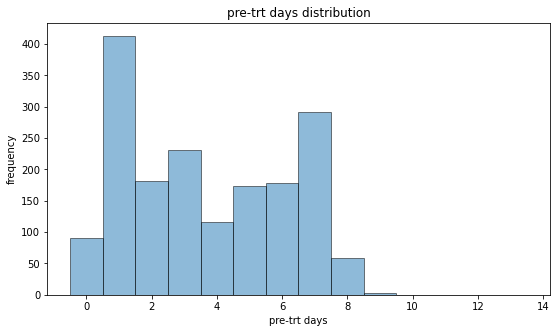

In [298]:
plt.figure(figsize=[9,5])
bins = range(0,15)

y = df_ins['PretrtDays']
plt.hist(y, bins = bins, alpha=0.5, edgecolor='black', align='left')

plt.xlabel('pre-trt days')
plt.ylabel('frequency')
plt.title('pre-trt days distribution')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [300]:
df_ins.to_excel("ins_201910_202002_MIP.xlsx")


In [ ]:
#df1920[df1920['Team']==1][['SimLocation','TxUnit']]

In [237]:
df_ins.SiteGroup.unique()

array(['CNS', 'Head & Neck', 'Gynae', 'Breast', 'GI Upper', 'Sarcoma',
       'Endocrine', 'Lung', 'Lymphoma', 'Paediatrics'], dtype=object)